## Import libraries

In [ ]:
import os
import time
import datetime
# from google.colab import drive

import pandas as pd
import seaborn as sns
import numpy as np
import random

import matplotlib.pyplot as plt
# !matplotlib inline

import torch
from torch.utils.data import Dataset, DataLoader, random_split, RandomSampler, SequentialSampler
torch.manual_seed(42)
!pip install transformers

from transformers import GPT2LMHeadModel,  GPT2Tokenizer, GPT2Config, GPT2LMHeadModel
from transformers import AdamW, get_linear_schedule_with_warmup

import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Load Dataset

In [ ]:
 
data=pd.read_csv('/content/drive/MyDrive/healthdataset/Medquad.csv')
df=data

In [ ]:
df.head()

,Question,Answer
0,What is (are) Adult Acute Lymphoblastic Leukem...,Key Points\n - Adult acute ...
1,What are the symptoms of Adult Acute Lymphobla...,"Signs and symptoms of adult ALL include fever,..."
2,How to diagnose Adult Acute Lymphoblastic Leuk...,Tests that examine the blood and bone marrow a...
3,What is the outlook for Adult Acute Lymphoblas...,Certain factors affect prognosis (chance of re...
4,Who is at risk for Adult Acute Lymphoblastic L...,Previous chemotherapy and exposure to radiatio...


In [ ]:
df.shape

(16412, 2)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16412 entries, 0 to 16411
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Question  16412 non-null  object
 1   Answer    16407 non-null  object
dtypes: object(2)
memory usage: 256.6+ KB


## Pre Processing data

In [ ]:
# Apply to the str method for the iration
df['Answer']=df['Answer'].apply(str)


In [ ]:
df.head()

,Question,Answer
0,What is (are) Adult Acute Lymphoblastic Leukem...,Key Points\n - Adult acute ...
1,What are the symptoms of Adult Acute Lymphobla...,"Signs and symptoms of adult ALL include fever,..."
2,How to diagnose Adult Acute Lymphoblastic Leuk...,Tests that examine the blood and bone marrow a...
3,What is the outlook for Adult Acute Lymphoblas...,Certain factors affect prognosis (chance of re...
4,Who is at risk for Adult Acute Lymphoblastic L...,Previous chemotherapy and exposure to radiatio...


In [ ]:
import re
#preprocessing questions and answers.
def decontractions(phrase):
    """decontracted takes text and convert contractions into natural form.
     ref: https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python/47091490#47091490"""
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"won\’t", "will not", phrase)
    phrase = re.sub(r"can\’t", "can not", phrase)
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    phrase = re.sub(r"n\’t", " not", phrase)
    phrase = re.sub(r"\’re", " are", phrase)
    phrase = re.sub(r"\’s", " is", phrase)
    phrase = re.sub(r"\’d", " would", phrase)
    phrase = re.sub(r"\’ll", " will", phrase)
    phrase = re.sub(r"\’t", " not", phrase)
    phrase = re.sub(r"\’ve", " have", phrase)
    phrase = re.sub(r"\’m", " am", phrase)
    phrase =re.sub("\s+" , " ", phrase)
    return phrase


def preprocess(text):
    # convert all the text into lower letters
    # remove the words betweent brakets ()
    # remove these characters: {'$', ')', '?', '"', '’', '.',  '°', '!', ';', '/', "'", '€', '%', ':', ',', '('}
    # replace these spl characters with space: '\u200b', '\xa0', '-', '/'
    
    text = decontractions(text)
    text = re.sub('[$)\?"’°!;\'€%:,(/]', '', text)
    text = re.sub('\u200b', ' ', text)
    text = re.sub('\xa0', ' ', text)
    return text


df['preprocess_Question'] = df['Question'].apply(preprocess)
df['preprocess_Answer'] = df['Answer'].apply(preprocess)
df.head()

,Question,Answer,preprocess_Question,preprocess_Answer
0,What is (are) Adult Acute Lymphoblastic Leukem...,Key Points\n - Adult acute ...,What is are Adult Acute Lymphoblastic Leukemia,Key Points - Adult acute lymphoblastic leukemi...
1,What are the symptoms of Adult Acute Lymphobla...,"Signs and symptoms of adult ALL include fever,...",What are the symptoms of Adult Acute Lymphobla...,Signs and symptoms of adult ALL include fever ...
2,How to diagnose Adult Acute Lymphoblastic Leuk...,Tests that examine the blood and bone marrow a...,How to diagnose Adult Acute Lymphoblastic Leuk...,Tests that examine the blood and bone marrow a...
3,What is the outlook for Adult Acute Lymphoblas...,Certain factors affect prognosis (chance of re...,What is the outlook for Adult Acute Lymphoblas...,Certain factors affect prognosis chance of rec...
4,Who is at risk for Adult Acute Lymphoblastic L...,Previous chemotherapy and exposure to radiatio...,Who is at risk for Adult Acute Lymphoblastic L...,Previous chemotherapy and exposure to radiatio...


In [ ]:
bios=df['preprocess_Answer']

In [ ]:
# for the count words inside the single sentence
df['question_len']=df['preprocess_Question'].apply(lambda x: len(x.split(' ')))
df['answer_len']=df['preprocess_Answer'].apply(lambda x: len(x.split(' ')))

In [ ]:
#printing different percentiles of question and answer lengths
import numpy as np
for i in range(0,100,5):
  print(i,np.percentile(df.question_len,i),np.percentile(df.answer_len,i))

0 3.0 1.0
5 5.0 26.0
10 5.0 42.0
15 6.0 51.0
20 6.0 61.0
25 6.0 71.0
30 7.0 84.0
35 7.0 98.0
40 7.0 111.0
45 8.0 124.0
50 8.0 138.0
55 8.0 155.0
60 9.0 174.0
65 9.0 199.0
70 9.0 232.0
75 10.0 252.0
80 10.0 279.0
85 11.0 315.0
90 11.0 380.0
95 12.0 524.0


In [ ]:
df.head()

,Question,Answer,preprocess_Question,preprocess_Answer,question_len,answer_len
0,What is (are) Adult Acute Lymphoblastic Leukem...,Key Points\n - Adult acute ...,What is are Adult Acute Lymphoblastic Leukemia,Key Points - Adult acute lymphoblastic leukemi...,8,436
1,What are the symptoms of Adult Acute Lymphobla...,"Signs and symptoms of adult ALL include fever,...",What are the symptoms of Adult Acute Lymphobla...,Signs and symptoms of adult ALL include fever ...,10,127
2,How to diagnose Adult Acute Lymphoblastic Leuk...,Tests that examine the blood and bone marrow a...,How to diagnose Adult Acute Lymphoblastic Leuk...,Tests that examine the blood and bone marrow a...,8,446
3,What is the outlook for Adult Acute Lymphoblas...,Certain factors affect prognosis (chance of re...,What is the outlook for Adult Acute Lymphoblas...,Certain factors affect prognosis chance of rec...,10,66
4,Who is at risk for Adult Acute Lymphoblastic L...,Previous chemotherapy and exposure to radiatio...,Who is at risk for Adult Acute Lymphoblastic L...,Previous chemotherapy and exposure to radiatio...,10,114


In [ ]:
df['preprocess_Answer'][0]

'Key Points - Adult acute lymphoblastic leukemia ALL is a type of cancer in which the bone marrow makes too many lymphocytes a type of white blood cell. - Leukemia may affect red blood cells white blood cells and platelets. - Previous chemotherapy and exposure to radiation may increase the risk of developing ALL. - Signs and symptoms of adult ALL include fever feeling tired and easy bruising or bleeding. - Tests that examine the blood and bone marrow are used to detect find and diagnose adult ALL. - Certain factors affect prognosis chance of recovery and treatment options. Adult acute lymphoblastic leukemia ALL is a type of cancer in which the bone marrow makes too many lymphocytes a type of white blood cell. Adult acute lymphoblastic leukemia ALL also called acute lymphocytic leukemia is a cancer of the blood and bone marrow. This type of cancer usually gets worse quickly if it is not treated. Leukemia may affect red blood cells white blood cells and platelets. Normally the bone marro

In [ ]:
bios = df['preprocess_Answer'] #just use the main bio text in this example
bios

0        Key Points - Adult acute lymphoblastic leukemi...
1        Signs and symptoms of adult ALL include fever ...
2        Tests that examine the blood and bone marrow a...
3        Certain factors affect prognosis chance of rec...
4        Previous chemotherapy and exposure to radiatio...
                               ...                        
16407    What are the signs and symptoms of 5q- syndrom...
16408    5q14.3 microdeletion syndrome is characterized...
16409    What are the signs and symptoms of 5q14.3 micr...
16410    What are the signs and symptoms of 8p23.1 dupl...
16411    What are the signs and symptoms of 8q12 microd...
Name: preprocess_Answer, Length: 16412, dtype: object

In [ ]:
biom = df['preprocess_Question'] #just use the main bio text in this example
biom

0          What is are Adult Acute Lymphoblastic Leukemia 
1        What are the symptoms of Adult Acute Lymphobla...
2        How to diagnose Adult Acute Lymphoblastic Leuk...
3        What is the outlook for Adult Acute Lymphoblas...
4        Who is at risk for Adult Acute Lymphoblastic L...
                               ...                        
16407               What are the symptoms of 5q- syndrome 
16408           What is are 5q14.3 microdeletion syndrome 
16409    What are the symptoms of 5q14.3 microdeletion ...
16410    What are the symptoms of 8p23.1 duplication sy...
16411    What are the symptoms of 8q12 microduplication...
Name: preprocess_Question, Length: 16412, dtype: object

[7 9 7 ... 8 8 8]


<Axes: ylabel='Count'>

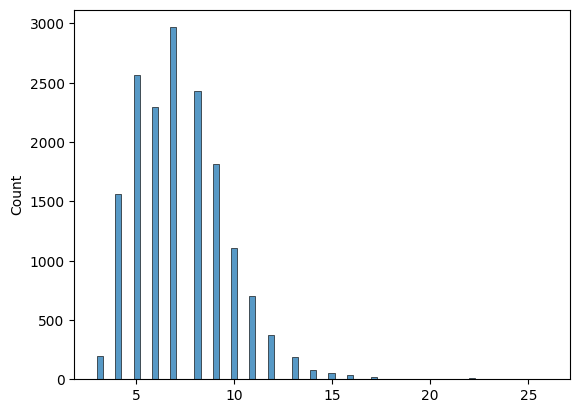

In [ ]:
doc_length = []

for bio in biom:

    # get rough token count distribution
    tokens = nltk.word_tokenize(bio)

    doc_length.append(len(tokens))

doc_length = np.array(doc_length)
print(doc_length)

sns.histplot(doc_length)

<Axes: ylabel='Count'>

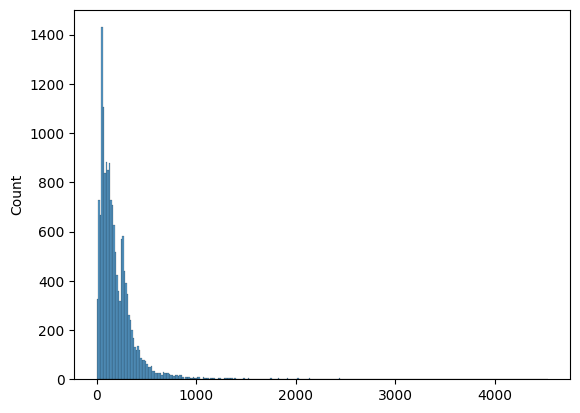

In [ ]:
doc_lengths = []

for bio in bios:

    # get rough token count distribution
    tokens = nltk.word_tokenize(bio)

    doc_lengths.append(len(tokens))

doc_lengths = np.array(doc_lengths)

sns.histplot(doc_lengths)

In [ ]:
doc_lengths
count = 0 
n=100

for value in doc_lengths:

    if value > n:
        count += 1

print("Number of values greater than",n,"are :", count)



Number of values greater than 100 are : 10795


In [ ]:
np.average(doc_lengths)

212.06696319766024

## Load GPT Tokenizer

In [ ]:

# Load the GPT tokenizer.
tokenizer = GPT2Tokenizer.from_pretrained('gpt2', bos_token='<|startoftext|>', eos_token='<|endoftext|>', pad_token='<|pad|>') #gpt2-medium

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:

print("The max model length is {} for this model, although the actual embedding size for GPT small is 768".format(tokenizer.model_max_length))
print("The beginning of sequence token {} token has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.bos_token_id), tokenizer.bos_token_id))
print("The end of sequence token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.eos_token_id), tokenizer.eos_token_id))
print("The padding token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.pad_token_id), tokenizer.pad_token_id))

The max model length is 1024 for this model, although the actual embedding size for GPT small is 768
The beginning of sequence token <|startoftext|> token has the id 50257
The end of sequence token <|endoftext|> has the id 50256
The padding token <|pad|> has the id 50258


In [ ]:
batch_size =8



## Tokenize dataset

In [ ]:
class GPT2Dataset(Dataset):

  def __init__(self, txt_list, tokenizer, gpt2_type="gpt2", max_length=500):

    self.tokenizer = tokenizer
    self.input_ids = []
    self.attn_masks = []

    for txt in txt_list:
      

      encodings_dict = tokenizer('<|startoftext|>'+ txt + '<|endoftext|>', truncation=True, max_length=max_length, padding="max_length")
      # print(encodings_dict)

      self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
      self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))
    
  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self, idx):
    return self.input_ids[idx], self.attn_masks[idx] 

In [ ]:
dataset = GPT2Dataset(bios, tokenizer, max_length=500)

# Split into training and validation sets
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

14,770 training samples
1,642 validation samples


In [ ]:
dataset

In [ ]:
# Create the DataLoaders for our training and validation datasets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

## Loading Model

In [ ]:
configuration = GPT2Config.from_pretrained('gpt2', output_hidden_states=False)


# instantiate the model
model = GPT2LMHeadModel.from_pretrained("gpt2", config=configuration)

# this step is necessary because I've added some tokens (bos_token, etc) to the embeddings
# otherwise the tokenizer and model tensors won't match up
model.resize_token_embeddings(len(tokenizer))

# Tell pytorch to run this model on the GPU.
device = torch.device("cuda")
model.cuda()

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [ ]:
# some parameters I cooked up that work reasonably well

epochs = 4
learning_rate = 5e-4
warmup_steps = 1e2
epsilon = 1e-8

# this produces sample output every 100 steps
sample_every = 100

In [ ]:

optimizer = AdamW(model.parameters(),
                  lr = learning_rate,
                  eps = epsilon
                )

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
# This changes the learning rate as the training loop progresses
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = warmup_steps, 
                                            num_training_steps = total_steps)

In [ ]:
def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))

## Training 

In [ ]:
total_t0 = time.time()

training_stats = []

model = model.to(device)

for epoch_i in range(0, epochs):
  
    # ========================================
    #               Training
    # ========================================

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()

    total_train_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        model.zero_grad()        

        outputs = model(  b_input_ids,
                          labels=b_labels, 
                          attention_mask = b_masks,
                          token_type_ids=None
                        )

        loss = outputs[0]  

        batch_loss = loss.item()
        total_train_loss += batch_loss

        # Get sample every x batches.
        if step % sample_every == 0 and not step == 0:

            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}. Loss: {:>5,}.   Elapsed: {:}.'.format(step, len(train_dataloader), batch_loss, elapsed))

            model.eval()

            sample_outputs = model.generate(
                                    bos_token_id=random.randint(1,30000),
                                    do_sample=True,   
                                    top_k=50, 
                                    max_length = 200,
                                    top_p=0.95, 
                                    num_return_sequences=1
                                )
            for i, sample_output in enumerate(sample_outputs):
                  print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))
            
            model.train()

        loss.backward()

        optimizer.step()

        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)       
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)
        
        with torch.no_grad():        

            outputs  = model(b_input_ids, 
#                            token_type_ids=None, 
                             attention_mask = b_masks,
                            labels=b_labels)
          
            loss = outputs[0]  
            
        batch_loss = loss.item()
        total_eval_loss += batch_loss        

    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    validation_time = format_time(time.time() - t0)    

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 4 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  1,847. Loss: 1.0183439254760742.   Elapsed: 0:01:58.
0:  bipartisanI am 505 out of 598 patients have been examined in a study that evaluated the health effects of intravenous fluid injection. Most of the cases are from non-small cells. Most of these cases are from healthy cells. Many of these people have severe liver damage or kidney failure. They often develop multiple forms of infections including cirrhosis and lung disease.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  1,847. Loss: 1.1308848857879639.   Elapsed: 0:04:01.
0:  increasingThe Human Phenotype Ontology provides the following list of signs and symptoms for Hashimoto-like syndrome. If the information is available the table below includes how often the symptom is seen in people with this condition. You can use the MedlinePlus Medical Dictionary to look up the definitions for these medical terms. Signs and Symptoms Approximate number of patients when available Abnormality of the central nervous system - Autosomal dominant inheritance - Atherosclerosis - Babyspherox - Cleft palate - Hypoplasia - Hypoplasia of the thyroid - Impaired blood flow - Iris or hair - Increased heart rate - Interstitial myopathy - Intestinal polycystic ovary - Low blood sugar - Malabsorption - Osteoporosis - Pesile - Polycystic ovary - Radiopathy - Progressive heart failure - Progressive respiratory failure - Respiratory failure - The Human Phenotype Ontology HPO has collected information on how often

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  1,847. Loss: 0.9539980888366699.   Elapsed: 0:06:04.
0: dayIn the case of SLS the condition is inherited - A person has an autosomal recessive condition which means both copies of the gene in each cell have mutations. The parents of an individual with a recessive condition each carry one copy of the mutated gene but they typically do not show signs and symptoms of the condition.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  1,847. Loss: 0.524217426776886.   Elapsed: 0:08:05.
0:  HangEchidioris syndrome is an inherited disorder involving an increased number of small arteries in the liver. These are cells that control blood flow to the body. Each branch is enlarged and the body can hold too many different amounts of blood. The amount that a person has in each liver is typically divided based on the size of the blockage and the amount of blood circulating in each liver cells. Individuals with Echidioris syndrome can have small coronary arteries in the back of the neck. They can also have high blood flow from the rectum and the abdomen. People with Echidioris syndrome can develop liver damage from too much blood. This type of liver damage can lead to an arrhythmia when blood reaches the bottom of the liver. Individuals who have the disease often have a short life span and need rehabilitation. This condition is inherited in an autosomal dominant pattern which means both copies of the gene in

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  1,847. Loss: 0.8700181245803833.   Elapsed: 0:10:07.
0:  foodsTreatment depends on the individual characteristics of the disorder the person has. Some people can have no symptoms of the disorder. Some people with a type of congenital hyperhidrosis syndrome have no symptoms but they may require corticosteroids for a long time. Most people with a congenital hyperhidrosis syndrome have no symptoms and may need treatment to prevent or delay the onset of symptoms in those with high blood cholesterol levels blood pressure high blood sugar excess fat or a buildup of small plaque-forming fluid in the body. However many people with an acquired familial high blood cholesterol have no history of high blood cholesterol levels at all and are normal bodys natural foods and physical activity.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  1,847. Loss: 0.6528775691986084.   Elapsed: 0:12:09.
0:  trailKnee osteochondritis is a condition that affects more than 1 in 4 people worldwide. The disease is characterized by joint cramping or cramping of joint bone as the pain develops more slowly. It is common in children younger than 5 who may be prone to pain and muscle weakness. It is typically diagnosed at early infancy but can occur in older adults. While individuals may develop knee osteochondritis at birth and may begin experiencing pain during the first year of life the condition is usually less severe with the risk being underdiagnosed.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  1,847. Loss: 1.0317977666854858.   Elapsed: 0:14:11.
0: intendWhat are the signs and symptoms of Cushing syndrome A type of congenital hypertension is a very rare type of hypertension that affects the blood vessels in the arms and legs. It can be caused by an abnormal or missing blood supply to the heart. Cushing syndrome is most common in people with extremely high levels of hypertension who experience frequent seizures or sudden heart arrhythmia. Other factors that could increase blood pressure in the arms and legs include a shortage of oxygen in the body or abnormally high blood pressure. Although the exact cause of Cushing syndrome is not known the exact underlying causes of the condition may also be complex. Researchers have proposed at least three possible family conditions as a possible risk factor for the condition. A mutation in the SCG1 gene associated with Cushing syndrome results in an unusually slow loss of normal blood supply that is accompanied by a su

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  1,847. Loss: 1.212421178817749.   Elapsed: 0:16:12.
0:  surroundArancy is a group of disorders that impair the brain and spinal cord. Arancy has been diagnosed in some individuals and is associated with other features such as sensorineural hearing loss seizures intellectual disability intellectual disability neuroplasticity speech impairments and multiple intellectual disorders such as Down syndrome and ADHD. In children who are at least four years old and are receiving supportive services in intensive care treatment and in treatment for developmental delays learning disabilities attention deficit hyperactivity disorder intellectual disability developmental delay and hearing loss intellectual disability are also affected. In addition to the developmental delay intellectual disability intellectual disability intellectual disability can include difficulties with thinking developmental delays learning disorders attention deficit hyperactivity disorder and mental health 

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  1,847. Loss: 0.6647221446037292.   Elapsed: 0:18:15.
0:  reflexWhat are the signs and symptoms of Severe congenital adrenal hypogammaglobulinemia The Human Phenotype Ontology provides the following list of signs and symptoms for Severe congenital adrenal hypogammaglobulinemia. If the information is available the table below includes how often the symptom is seen in people with this condition. You can use the MedlinePlus Medical Dictionary to look up the definitions for these medical terms. Signs and Symptoms Approximate number of patients when available AplasiaHypoplasia of the external ureters 90 Abnormality of the palate 50 Anterior fontanel 50 Cataract 50 Clinodactyly of the 5th finger 50 Cleft palate 50 Deeply set nasal bridge 50 Erector erythema 50 Hypertelorism 50 Intellectual disability 50 Nystagmus 50 Prominent occiput 50 Prominent supraorbital ridges 50 Short philtrum 50 Short long philtr


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  1,847. Loss: 0.9304545521736145.   Elapsed: 0:20:17.
0:  displayMost cases result from random events that occur in the environment that are not part of the normal course of the disease. For example there are three types of inheritance disorders called autosomal dominant inheritance disorders called dominant inheritance disorders. The following types of inheritance are typically inherited in an autosomal dominant or autosomal recessive manner. People with this condition are usually the first to inherit an altered copy of the gene but do not inherit the mutated gene. People with this condition can pass on the altered gene to their children but do not have symptoms until they reach their 50th decade of life. These parents may be more likely to be affected than people with the autosomal recessive condition because they are carriers. Some people with this condition are carriers of a deleted copy of the gene but do not show signs and symptoms of the condition. However the 

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  1,847. Loss: 0.6856081485748291.   Elapsed: 0:22:19.
0:  pastorNostalgia is a type of neurasthenia that can include numbness or weakness in the arms arm andor leg muscles the nerves that transmit pain to the muscles of the arm and leg muscles the nerves that control eye movement and sensory processing. Some people with this condition have a condition called retinitis pigmentosa which also called retinitis pigmentosa with an unknown cause. In most individuals with this disorder retinitis pigmentosa develops throughout childhood including the first few months of life and is present in a small number of people throughout childhood. However as the condition progresses people will develop severe symptoms of retinitis pigmentosa without the signs and symptoms of the condition and the condition is not always controlled by specific treatments. The goal of the following treatments is to treat retinitis pigmentosa with proper treatment and management of symptoms. This includes

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,200  of  1,847. Loss: 0.8400219678878784.   Elapsed: 0:24:21.
0:  illicitIn most cases a man carries two or more miscarriages because the uterus is too large or because a woman miscarries. Many women who have an infertile pregnancy also carry one or more miscarriages because the eggs or sperm are near the end of their cell division. These pregnancies occur in a person is lifetime as compared one to five pregnancies an infertile pregnancy. Some of these pregnancies result from an abnormal pregnancy. For example a man may be infertile as a result of having an enlarged testis which normally allows for sperm to enter the testes instead of from the uterus. In a few pregnancies an abnormal pregnancy occurs but the fertilized egg or sperm does not mature and fertilize normally. Usually an enlarged testis enlarges a man does not. Sometimes a uterus has normal vaginal bleeding and sometimes it does not. During a pregnancy it is important to prevent an abnormal pregnancy. To avoid thes

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,300  of  1,847. Loss: 0.3886554539203644.   Elapsed: 0:26:24.
0:  LiberationWhat causes hereditary spastic paraparesis The cause of hereditary spastic paraparesis is unknown. It is likely that the protein produced from a single spastic protein in the brain leads to the specific symptoms seen in hereditary spastic paraparesis. The function of the spastic protein is thought to be critical in the early development of children with a variety of neurological symptoms such as poor concentration or poor motor skills dysarthria. It is unclear why spastic paraparesis may be acquired during childhood and that the proteins produced from the genes in the spastic protein family are present in the brain is cells throughout the developing embryo. Spastic paraparesis is typically not inherited but is passed from parent to child through an mtDNA mutation. About 80 percent of hereditary spastic paraparesis is inherited in an autosomal recessive pattern.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,400  of  1,847. Loss: 0.9477224349975586.   Elapsed: 0:28:26.
0:  NamDegenerative pulmonary disease DVD typically occurs in people between the ages of 40 and 85. The main symptom of DVD is a buildup of fluid in the lungs. The fluid in the lungs is called the pulmonary mucosa. The mucosa has two main components called the tropiolentrin and the mucosa-endotheliomatous. Within the pulmonary mucosa there are three separate mucoscoles - Tropiolentrin mucosa which contains three mucoscoles and Tropiolentrin mucosa which contains two mucoscoles and Tropiolentrin mucosa which contains one and the third. The mucosa is thick and clear especially on the palms of the hands and feet. People usually develop signs and symptoms of DVD around age 45. Some people develop problems starting or worsening of their heart attacks. The blood around the heart may swell and burst causing signs and symptoms of DVD. Because these blood vessels leak blood oxygenated blood supply from the


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,500  of  1,847. Loss: 0.8993651866912842.   Elapsed: 0:30:28.
0: IONThese resources address the diagnosis or management of myocardiomyopathy - Genetic Testing Registry Myocardiomyopathy of the pulmonary artery These resources from MedlinePlus offer information about the diagnosis and management of various health conditions - Diagnostic Tests - Drug Therapy - Surgery and Rehabilitation - Genetic Counseling - Palliative Care


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,600  of  1,847. Loss: 0.5257254242897034.   Elapsed: 0:32:29.
0:  glimpseTreatment depends on the size of the tumor and how long it has been. If you have a new tumor it can take several months to several years to recur. Treatment for other types of leukemia is generally slow and effective. However if you have cancer as you get older and it has spread to other parts of the body it may not respond as expected. The same can happen to other types of leukemia. Treatment can help relieve some of these symptoms but it is most effective if it is performed alone. People who are more sensitive to radiation therapy are among the most likely to develop leukemia. The only real way to stop cancer from recurring is to get better treatment. Patients who are very sensitive to radiation therapy may not want to go back to work until the cancer has recurred.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,700  of  1,847. Loss: 0.5917767882347107.   Elapsed: 0:34:30.
0:  LaureMutations in the FGFR3 gene have been identified in approximately 85 percent of individuals with hemochromatosis. These mutations significantly reduce the amount of alpha-synuclein nucleic acid ATP a component of DNA. When a mutation in the FGFR3 gene is found it reduces the amount of alpha-synuclein nucleic acid ATP a component of DNA. When a mutation in the FGFR3 gene is found it reduces the amount of an enzyme called guanine kinase II. The enzyme normally performs this job in the cell. When enzyme deficiency occurs individuals with hemochromatosis begin to have problems with their function. About half of these individuals may have problems with their vision ataxia hypotonia peripheral neuropathy muscle weakness muscle weakness or spasticity. The remaining 5 to 10 percent have complete vision loss in both eyes. The loss of visual acuity causes difficulty with walking and walking ataxia and spasticity. So

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,800  of  1,847. Loss: 0.8464031219482422.   Elapsed: 0:36:33.
0: ismThe exact prevalence of the non-inherited type of NINDS is unknown. NINDS type 1 is the rarest subtype of the disorder.

  Average training loss: 1.07
  Training epoch took: 0:37:28

Running Validation...
  Validation Loss: 0.76
  Validation took: 0:01:19

======== Epoch 2 / 4 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  1,847. Loss: 0.4296884834766388.   Elapsed: 0:02:00.
0: ounTumor necrosis factor necrosis factor deficiency is caused by mutations in one of four genes that are located on the long q arm of the q arm of the long Q gene. The genes that provide instructions for making proteins involved in bone growth and reproduction are the HT1B and HT2A genes. The HT1B gene provides instructions for making a protein called heparan sulfate. HT2A gene provides instructions for making an enzyme called alin. Mutations in the HT1B gene cause this enzyme to function as it is not normally functioning. The HT2A gene provides instructions for making a protein called heparan sulfate. Mutations in the HT1B gene disrupt the normal function of heparan sulfate causing it to be unable to provide enough alsin. The heparan sulfate protein is also unable to perform its usual function while the body is growing.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  1,847. Loss: 0.4880516529083252.   Elapsed: 0:04:02.
0:  electionWhat are the signs and symptoms of X-linked intellectual disability Syndactyly The Human Phenotype Ontology provides the following list of signs and symptoms for X-linked intellectual disability Syndactyly. If the information is available the table below includes how often the symptom is seen in people with this condition. You can use the MedlinePlus Medical Dictionary to look up the definitions for these medical terms. Signs and Symptoms Approximate number of patients when available Autosomal recessive inheritance - Axial foot drop - Dural gait - Distal gait - Episodic tetany - Flexion contracture - Hypertrophy - Intellectual disability - Lepto-oliosis - Leptomyopathy - Macrotia - Myoclonus - Posteriorly rotated ears - Proximal placement of the toes - Scoliosis - Short stature - Spina bifida occulta - Slow progression - The Human Phenotype Ontology HPO has collected information on how often


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  1,847. Loss: 0.5858370661735535.   Elapsed: 0:06:04.
0:  crazyNew types of treatment are being tested in clinical trials. This summary section describes treatments that are being studied in clinical trials. It may not mention every new treatment being studied. Information about clinical trials is available from the NCI website. High-dose chemotherapy with stem cell transplant High doses of chemotherapy with stem cell transplant are given to help kill cancer cells and stem cells that have spread within the blood. This type of treatment is also called cryoprecipitate chemotherapy and is being studied as a treatment for chronic lymphocytic leukemia.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  1,847. Loss: 0.3919442892074585.   Elapsed: 0:08:05.
0:  benchWhat are the signs and symptoms of Charcot-Marie-Tooth disease type 2 The Human Phenotype Ontology provides the following list of signs and symptoms for Charcot-Marie-Tooth disease type 2. If the information is available the table below includes how often the symptom is seen in people with this condition. You can use the MedlinePlus Medical Dictionary to look up the definitions for these medical terms. Signs and Symptoms Approximate number of patients when available Acanthocytosis nigricans 90 Cataract 90 Congenital cataract 90 Decreased antibody level in blood 50 Hernia of the abdominal wall 50 Increased antibody level in blood 50 Natal tooth 50 Myoclonic seizures 50 Polycystic kidney dysplasia 50 Pulmonary hypertension 50 Recurrent respiratory infections 50 Short stature 50 Strabismus 50 Abnormality of calvarial morphology - Autosomal recessive inheritance - Decreased antibody level in blood - Delayed sk

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  1,847. Loss: 0.49215319752693176.   Elapsed: 0:10:07.
0:  incorporatedThis condition is inherited in an autosomal recessive pattern which means both copies of the gene in each cell have mutations. The parents of an individual with an autosomal recessive condition each carry one copy of the mutated gene but they typically do not show signs and symptoms of the condition.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  1,847. Loss: 0.7720563411712646.   Elapsed: 0:12:07.
0: PeterThere is no cure for spondyloepimetaphyseal dysplasia. Treatment depends on the cause of the disorder and the size of the tumor. Surgery may be necessary for some tumors. Surgery may also correct other problems that appear to be related to spondyloepimetaphyseal dysplasia such as bone abnormalities.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  1,847. Loss: 0.6039231419563293.   Elapsed: 0:14:07.
0: uringHow is fibroids calcification and fibrosarcoma diagnosed A diagnosis of fibroids calcification and fibrosarcoma may include multiple endocrine neoplasia thyroid nodular cancer cancer subcutaneous fibroids and some tumors that have calcifications or fibrosarcoma. Treatment generally consists of surgery to remove the endocrine neoplasia and a wide range of hormone therapy to reduce the swelling andor fatigue.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  1,847. Loss: 1.0705883502960205.   Elapsed: 0:16:07.
0:  reproductiveX-linked juvenile hypertrichosis XLS is a neurological disorder that primarily affects the nervous system. Affected children with XLS usually have involuntary muscle jerks twitches or tics in their limbs that cause them to become unresponsive to stimuli such as pain tics or noise. The signs and symptoms of XLS vary widely among affected individuals and the extent of this disorder is not known. Children with XLS typically learn to recognize and respond to other people in various ways. Some affected people may be more physically active than other children. Intelligence is normal among males but this group also tends to be more mobile than females and more responsive to stimuli. Developmental problems may also be more difficult to treat. Some affected children experience involuntary jerking movements on their feet or wrists. These movements may be triggered by other activities including biting scratchi

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  1,847. Loss: 0.5194123387336731.   Elapsed: 0:18:09.
0:  zoneWhat are the signs and symptoms of Hereditary hepatitis 14 The Human Phenotype Ontology provides the following list of signs and symptoms for Hereditary hepatitis 14. If the information is available the table below includes how often the symptom is seen in people with this condition. You can use the MedlinePlus Medical Dictionary to look up the definitions for these medical terms. Signs and Symptoms Approximate number of patients when available Abnormal pyramidal signs - Abnormal pyramidal signs - Acrocyanosis - Autosomal recessive inheritance - Bacterial hepatitis - Bacterial cystic fibrosis - Cardiomyopathy - Hemolytic anemia - Hepatomegaly - Hepatomegaly - Hyperbilirubinemia - Increased red cell production - Neutropenia - Multiple lipomas - Pancytopenia - Recurrent hepatic hepatic disease - Recurrent hepatomegaly - Recurrent liver failure - Recurrent liver failure - Recurrent inflammation of


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  1,847. Loss: 0.9309698939323425.   Elapsed: 0:20:11.
0:  commitsThese resources address the diagnosis or management of hypophosphatemia congenital infantile with breathing problems - Genetic Testing Registry Hypophosphatemia congenital - National Heart Lung and Blood Institute Hypophosphatemic Congenital - United Mitochondrial Disease Foundation Hypophosphatemic - University of Chicago College of Medical Sciences Hypophosphatemic Congenital These resources from MedlinePlus offer information about the diagnosis and management of various health conditions - Diagnostic Tests - Drug Therapy - Surgery and Rehabilitation - Genetic Counseling - Palliative Care


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  1,847. Loss: 0.9225995540618896.   Elapsed: 0:22:11.
0:  ironyWhat causes Kleefstra syndrome Kleefstra syndrome is caused by mutations in the WNT gene. The WNT gene provides instructions for making a protein called WNT-1. This protein acts as a receptor for the X chromosome which is the chromosome in which cells develop. It is important for normal development because it regulates the activity of genes that determine how and when genes are active in cells. WNT-1 attaches binds to other genes involved in the formation of egg and sperm cells. These genes have specific functions in embryonic development but WNT-1 is not needed for normal sperm growth and development. In some cases however it is not needed for the sperm cells to form egg and egg cell fragments. In some cases when the WNT gene is mutated it is unclear how the resulting protein damages genes involved in embryonic development.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,200  of  1,847. Loss: 0.599658727645874.   Elapsed: 0:24:12.
0:  SahSummary  My personal and professional history can identify many risk factors for prostate cancer. Most risk factors include age smoking being white male or being exposed to certain chemicals. People who think they may be at risk also may think about certain lifestyle changes. These lifestyle changes include taking a long lifestyle such as being overweight or very inactive including exercising every day. Avoiding prescription and over-the-counter medicines or vitamins may also play a role in risk. These medicines are used to treat cancer but they do not prevent prostate cancer. The most important risk factor for prostate cancer is the presence of prolactin. Prolactin acts like natural prolactin. A type of prolactin is found in lupus and acantholytic acid. It is usually detected at the time of the diagnosis. Prolactin increases the level of testosterone in the bloodstream but not in the blood. It can also affec

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,300  of  1,847. Loss: 0.5678932070732117.   Elapsed: 0:26:13.
0:  BryanHow might familial myofibrillar cysts be treated Treatment is symptomatic. Supportive care is necessary by local specialists who work with the patient. People with familial myofibrillar cysts often need a general practitioner and an experienced pediatrician to help with the specific problems of the condition.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,400  of  1,847. Loss: 0.5370561480522156.   Elapsed: 0:28:13.
0:  spiritsThese resources address the diagnosis or management of primary hypoxanthosis nigricans - Gene Review Gene Review Primary Hypoxanthosis Nigricans - Genetic Testing Registry Primary hypoxanthosis nigricans - MedlinePlus Encyclopedia Prolonged-Hepatic Serum Deficiency These resources from MedlinePlus offer information about the diagnosis and management of various health conditions - Diagnostic Tests - Drug Therapy - Surgery and Rehabilitation - Genetic Counseling - Palliative Care


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,500  of  1,847. Loss: 0.7386237382888794.   Elapsed: 0:30:13.
0:  seesHow might multiple lipomas be treated There is no specific treatment for lipomas that require treatment. Medications used to treat lipomas may include nonsteroidal anti-inflammatory drugs NSAIDs and sometimes laser phototherapy. Top of page Surgery There may be the option of surgery to remove the lipomas or remove some of their tissues. Surgery typically involves immobilizing the tissue and sometimes removing a piece from the lip for another cosmetic reason. If the lipoma cannot be removed or the tumor cannot be cured removal of the whole lip is usually necessary. Radiation Therapy Radiation therapy is the most common treatment for lipomas. Patients may want to avoid contact with or close to radiation therapy for signs of advanced cancer. Because lipomas can be resistant to radiation therapy they cannot grow and spread and the tumors can stay there for decades.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,600  of  1,847. Loss: 0.7732185125350952.   Elapsed: 0:32:14.
0:  hungryMyasthenia gravis is a disorder of immune system function which occurs if the immune system recognizes the body is own proteins from outside the body is normal complement system. Normally the complement system makes antibodies that attack the proteins but occasionally antibodies from the normal complement system destroy them or impair the bodys ability to fight them. Myasthenia gravis can be brought on by a variety of foreign invaders such as viruses or bacteria. A person with this condition may also experience a rash or itching. Signs and symptoms include a fever rash sometimes accompanied by fever chills skin rash accompanied by purpura andor joint pain. The exact cause of myasthenia gravis is unknown.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,700  of  1,847. Loss: 0.8170985579490662.   Elapsed: 0:34:14.
0:  PTHow is Noonan syndrome inherited Noonan syndrome is inherited in an autosomal dominant pattern which means one copy of the altered gene in each cell is sufficient to cause the disorder. People who inherit an altered gene are more likely than people who do not have a mutation to have the condition. Most cases of Noonan syndrome are not inherited from an affected parent however they can occur in people who have a history of the disorder.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,800  of  1,847. Loss: 0.6971973180770874.   Elapsed: 0:36:14.
0: üThe prognosis for individuals with ZSS varies depending on the size of the tumor and whether the cancer has spread beyond the colon and rectum. With a few exceptions treatment often works best when there is no known cancerous tumor. If only a small tumor is left a person may benefit from surgical resection of the large tumor. A large tumor may become a tumor and only require surgery to remove it. For those with a colon resection in which the colon has become a normal part of the colon the surgeon may remove the colon at some stage. If a large tumor is left after surgery surgery it may remain a colon resection. If a large tumor is left after surgery it may still need to be removed. Because many individuals with ZSS benefit from treatment they can have regular surgery as needed. However because there is often a mass to be removed surgery may be the only time most patients will need large surgery.

  Average train

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  1,847. Loss: 0.4100884795188904.   Elapsed: 0:01:59.
0: ruceThese resources address the diagnosis or management of oculocutaneous albinism - Gene Review Gene Review Autosomal Dominant Albinism - Genetic Testing Registry Albinism familial - National Heart Lung and Blood Institute How is Albinism Treated - National Heart Lung and Blood Institute How is Albinism Treated These resources from MedlinePlus offer information about the diagnosis and management of various health conditions - Diagnostic Tests - Drug Therapy - Surgery and Rehabilitation - Genetic Counseling - Palliative Care


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  1,847. Loss: 0.7946134209632874.   Elapsed: 0:04:00.
0:  derivativesKey Points - Avoiding risk factors and increasing protective factors may help prevent cancer. - The following are risk factors for ovarian fallopian tube and fallopian stromal cancer - The following are protective factors for ovarian fallopian tube and fallopian stromal cancer - The following are protective factors for ovarian fallopian tube and fallopian stromal cancer - Risk-reducing salpingo-oophorectomy salpingo-urea salpingo-oophorectomy and ovarian fallopian tube - The following are risk factors for ovarian fallopian tube and fallopian stromal cancer - The following are protective factors for ovarian fallopian tube and fallopian stromal cancer - The following are the stages of ovarian fallopian tube and fallopian stromal cancer - Stage 0 carcinoma in situ ovarian cell carcinoma - Stage I ovarian carcinoma in situ ovarian cell carcinoma and Stage II ovarian carcinoma in situ ovarian cell carcino

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  1,847. Loss: 0.5881838202476501.   Elapsed: 0:06:01.
0: Sarcosclerosis is a cancer that develops in cells of the lower abdomen. The lower abdomen is part of the bodys digestive system. It helps prevent digestion. In cancer the upper abdomen produces fluid that the body needs. It helps fight infection. Sarcosclerosis occurs most often in the stomach. It is also more common in the brain and in the nervous system. It most often develops in nerve cells. In the small intestine the tumor is often found first in the small intestine. It rarely spreads to the rest of the body. Symptoms may include - Headaches and abdominal pain - Aching or tight muscles - Coughing and gas - The doctor may take two or more prescription and over-the-counter medicines to treat the symptoms. - Weight loss - Feeling very hungry - Frequent diarrhea Cancers of the abdomen can not be cured and treatment is aimed at controlling the symptoms. In the past surgery to remove an entire cancer or other mal

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  1,847. Loss: 0.996839165687561.   Elapsed: 0:08:02.
0:  rememberingWhat causes congenital polycythemia congenita The exact cause of congenital polycythemia congenita CPP is unknown. It is thought to be caused by mutations in a specific gene called NCF5 or SCN5A. It is thought to have an autosomal dominant inheritance pattern which means one copy of the altered gene in each cell is sufficient to cause the disorder. If a mutation in the NCF5 gene is responsible for CPP the condition typically has an autosomal recessive pattern of inheritance. Affected individuals usually have no history of the disorder in their family. Rarely the condition has been associated with genetic disorders that have not yet been identified. Most of these genetic conditions involve the X-linked recessive pattern of inheritance which means two copies of the altered gene in each cell are altered. These cases occur in people with no history of the disorder in their family.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  1,847. Loss: 0.5666763186454773.   Elapsed: 0:10:04.
0:  SourcesThese resources address the diagnosis or management of BSS - Baby is First Test - Gene Review Gene Review BSS - Genetic Testing Registry BSS - MedlinePlus Encyclopedia BSS - MedlinePlus Encyclopedia BSS - MedlinePlus Encyclopedia Chest Pain - MedlinePlus Health Topic BSS - MedlinePlus Health Topic BSS - MedlinePlus Health Topic BSS - MedlinePlus Health Topic BSS - MedlinePlus Health Topic BSS - MedlinePlus Health Topic BSS - Palliative Care


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  1,847. Loss: 0.5561566352844238.   Elapsed: 0:12:04.
0: emsThese resources address the diagnosis or management of hereditary fructose intolerance - Gene Review Gene Review Hereditary Fructose Intolerance - Genetic Testing Registry Hereditary fructose intolerance familial 1 - Genetic Testing Registry Hereditary fructose intolerance familial 2 - Genetic Testing Registry Hereditary fructose intolerance familial 3 - Genetic Testing Registry Hereditary fructose intolerance familial 4 These resources from MedlinePlus offer information about the diagnosis and management of various health conditions - Diagnostic Tests - Drug Therapy - Surgery and Rehabilitation - Genetic Counseling - Palliative Care


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  1,847. Loss: 0.7615066766738892.   Elapsed: 0:14:04.
0: tzAicardi syndrome is caused by mutations in the ANOS1B gene and is inherited in an autosomal recessive pattern which means both copies of the gene in each cell have mutations. The parents of an individual with an autosomal recessive condition each carry one copy of the mutated gene but they typically do not show signs and symptoms of the condition.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  1,847. Loss: 0.573964536190033.   Elapsed: 0:16:04.
0: maticKey Points - There are different types of treatment for patients with transitional cell cancer of the renal pelvis and ribs. - Four types of standard treatment are used - Surgery - Radiation therapy - New types of treatment are being tested in clinical trials. - Chemotherapy - High-dose chemotherapy with stem cell transplant - High-dose chemotherapy with stem cell transplant - Biologic therapy - Patients may want to think about taking part in a clinical trial. - Patients can enter clinical trials before during or after starting their cancer treatment. - Follow-up tests may be needed. There are different types of treatment for patients with transitional cell cancer of the renal pelvis and ribs. Different types of treatments are available for patients with transitional cell cancer of the renal pelvis and ribs. Some treatments are standard the currently used treatment and some are being tested in clinical trial

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  1,847. Loss: 0.7376663088798523.   Elapsed: 0:18:05.
0:  syndThe risk of developing alpha thalassemia is estimated to be 1 in 200000 people per year in the general population and is also rare in certain groups of people. Although this risk may be high for people who have no family history of the condition this is not a random occurrence.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  1,847. Loss: 0.4198606610298157.   Elapsed: 0:20:05.
0:  gamA health care provider diagnoses colorectal cancer when - blood tests show that the lining of the colon is inflamed colorectal polyps. - a biopsy of the colon when there is a palpable abdominal mass. - a biopsy of the colon when the colon has just been diagnosed - colonoscopy is a procedure to look inside the rectum and colon to check for blood and bowel polyps. - a colonoscope is used to look at the rectum and colon for polyps. The colonoscope is inserted through a hollow opening in the abdomen about 4 inches long and is about the size of a small stone or a fist. A small colostomy is inserted through a narrow opening to one of these openings. The colostomy is inserted through one of two large or small valves on the same side of the colon. The colon is joined to the rectum by a long thin tube called a colostomy. The colon is partly covered by a plastic cover on


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  1,847. Loss: 0.301055371761322.   Elapsed: 0:22:06.
0:  injuryNew types of treatment are being tested in clinical trials. This summary section describes treatments that are being studied in clinical trials. It may not mention every new treatment being studied. Information about clinical trials is available from the NCI website. Radiosensitizers Radiosensitizers are drugs that make cancer cells more sensitive to radiation therapy than normal cells and stop dividing. Combining radiation therapy and biological therapy also are being studied. Patients may want to think about taking part in a clinical trial. For some patients taking part in a clinical trial may be the best treatment choice. Clinical trials are part of the cancer research process. Clinical trials are done to find out if new cancer treatments are safe and effective or better than the standard treatment. Many of today is standard treatments for cancer are based on earlier clinical trials. Patients who take p

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,200  of  1,847. Loss: 0.5226200222969055.   Elapsed: 0:24:08.
0: azaThe prognosis for children with Wilson disease varies depending on the severity of symptoms. The extent of muscle weakness and paralysis may be as small as a few millimeters and may last as long as a few weeks. Some children are not able to walk without assistance. Recovery for both adults and children is usually complete within 24 months. Life span depends on the age and location of the motor neuron in the liver as well as the level of calcium calcification in the liver.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,300  of  1,847. Loss: 0.4181717038154602.   Elapsed: 0:26:08.
0:  membraneMost cases of the syndrome occur in people with no history of the disorder in their family. About 40 percent of cases are familial. This phenomenon is called genomic imprinting. Each copy of the gene in each cell is called a carrier. Carriers of an autosomal recessive condition usually do not have any associated signs or symptoms. When two carriers of an autosomal recessive condition have children each child has a 25 1 in 4 risk to have the condition a 50 1 in 2 risk to be a carrier like each of the parents and a 25 chance to not have the condition and not be a carrier.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,400  of  1,847. Loss: 0.5565201640129089.   Elapsed: 0:28:08.
0: ijing- A family history of heart disease or lung disease raises the risk of a heart attack. - Smoking andor other environmental factors can cause heart disease or lung disease. - In some cases a person with heart disease has no signs or symptoms of heart failure. - People with heart failure also do not have lung diseases such as a form of inflammatory cardiomyopathy or scarring of the heart muscle. - Older age and being exposed to certain toxic substances also raises the risk of heart attack and lung disease. - The risk of heart attacks increases as you age but you may never know you have heart disease and heart failure. - If you have any signs or symptoms of heart failure call 911 right away. - Do not drive to a hospital for an emergency. If you have any of these symptoms call the ambulance so you and your doctor can begin life-saving treatment.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,500  of  1,847. Loss: 0.5263734459877014.   Elapsed: 0:30:09.
0:  castThese resources address the diagnosis or management of Kallmann syndrome - Genetic Testing Registry Kallmann syndrome These resources from MedlinePlus offer information about the diagnosis and management of various health conditions - Diagnostic Tests - Drug Therapy - Surgery and Rehabilitation - Genetic Counseling - Palliative Care


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,600  of  1,847. Loss: 0.447761595249176.   Elapsed: 0:32:09.
0:  purchWhat are the signs and symptoms of Trichothiodystrophy The Human Phenotype Ontology provides the following list of signs and symptoms for Trichothiodystrophy. If the information is available the table below includes how often the symptom is seen in people with this condition. You can use the MedlinePlus Medical Dictionary to look up the definitions for these medical terms. Signs and Symptoms Approximate number of patients when available Anteverted nares 90 Cognitive impairment 90 Epicanthus 90 High forehead 90 Macrotia 90 Muscular hypotonia 90 Opacification of the corneal stroma 90 Short stature 90 Split hand 90 Wide nasal bridge 90 Abnormality of movement 50 Abnormality of the hip bone 50 Anemia 50 AplasiaHypoplasia of the corpus callosum 50 Attention deficit hyperactivity disorder 50 AplasiaHypoplasia of the skin 50 Arrhythmia 50 Cerebral calcification 50 Chondrocalcinosis 50 Congestive heart


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,700  of  1,847. Loss: 0.43528640270233154.   Elapsed: 0:34:10.
0:  shouldersWhat are the signs and symptoms of CLCN4-related osteoarthritis The Human Phenotype Ontology provides the following list of signs and symptoms for CLCN4-related osteoarthritis. If the information is available the table below includes how often the symptom is seen in people with this condition. You can use the MedlinePlus Medical Dictionary to look up the definitions for these medical terms. Signs and Symptoms Approximate number of patients when available Abnormality of movement 90 Joint hypermobility 90 Osteoarthritis 90 Arthritis - Autosomal dominant inheritance - The Human Phenotype Ontology HPO has collected information on how often a sign or symptom occurs in a condition. Much of this information comes from Orphanet a European rare disease database. The frequency of a sign or symptom is usually listed as a rough estimate of the percentage of patients who have that feature. The frequency may also b

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,800  of  1,847. Loss: 0.6077935695648193.   Elapsed: 0:36:11.
0:  builtWhat are the signs and symptoms of Achondrogenesis skeletal dysplasia X-linked The Human Phenotype Ontology provides the following list of signs and symptoms for Achondrogenesis skeletal dysplasia X-linked. If the information is available the table below includes how often the symptom is seen in people with this condition. You can use the MedlinePlus Medical Dictionary to look up the definitions for these medical terms. Signs and Symptoms Approximate number of patients when available Abnormality of the skeletal system - Autosomal recessive inheritance - Fibular aplasia - The Human Phenotype Ontology HPO has collected information on how often a sign or symptom occurs in a condition. Much of this information comes from Orphanet a European rare disease database. The frequency of a sign or symptom is usually listed as a rough estimate of the percentage of patients who have that feature. The frequency may also 

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  1,847. Loss: 0.7953168153762817.   Elapsed: 0:01:59.
0:  openlyKey Points - There are different types of treatment for childhood central nervous system CNS germ cell tumors. - Children with childhood central nervous system CNS germ cell tumors should have their treatment planned by a team of health care providers who are experts in treating childhood CNS germ cell tumors. - There are different types of treatment for childhood central nervous system CNS germ cell tumors. - Children with childhood central nervous system CNS germ cell tumors should have their treatment planned by a team of health care providers who are experts in treating childhood CNS germ cell tumors. Some treatments are standard the currently used treatment and some are being tested in clinical trials. A treatment clinical trial is a research study meant to help improve current treatments or obtain information on new treatments for patients with cancer. When clinical trials show that a new treatment 

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  1,847. Loss: 0.9590571522712708.   Elapsed: 0:04:01.
0:  haltedMutations in the SCN4A SCN6A and TRPM4 genes cause primary carnitine deficiency. These genes provide instructions for making enzymes called beta- and carnitine oxidase A respectively. Beta- and carnitine oxidase A are found in liver cells and other tissues although they also release some carnitine. Carnitine helps the body make certain proteins called carnitine-containing fatty acids also known as fatty acids. Carnitine also plays a role in the formation and breakdown of fats called triglycerides. Triglycerides are the main source of stored energy for cells and tissues. Fatty acids also help produce bile and help process carbohydrates fat-soluble vitamins and certain fats lipids. Mutations in the SCN4A and SCN6A genes disrupt the activity of beta- and carnitine oxidase A respectively. As a result fats and triglycerides accumulate to form a fatty acid called acetyl-CoA oxidase


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  1,847. Loss: 0.6519293785095215.   Elapsed: 0:06:02.
0:  NikMNT stands for microscopic epidermolysis bullosa and is a tumor of the epidermolytic part of the epidermis the material that protects and protects the blood vessels that make blood. This condition also called microscopic melanocytic papules MOPs is a type of skin cancer caused by small cell lung cancer called mucopolysaccharidosis MPSC. Unlike most skin cancers MNTs involve an abnormal buildup of epidermal DNA a DNA sequence in the cell that changes the pigmentation of the skin and nails. Individuals with mucopolysaccharidosis MPSC commonly have no features related to the condition. In about 10 of cases the underlying genetic cause of the condition is unknown.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  1,847. Loss: 0.4309033751487732.   Elapsed: 0:08:03.
0:  tinMutations in the H1N1 gene cause hereditary motor neuropathy. The H1N1 gene provides instructions for producing the heparan sulfate hydroxylase enzyme. This enzyme is involved in the heparan sulfate excretion in the blood. Mutations in the H1N1 gene lead to the production of an enzyme with reduced function or cause a deficiency of the enzyme. Without enough heparan sulfate excretion in the blood the body cannot effectively process the compound. As a result compounds called reactive oxygen species accumulate in liver cells leading to jaundice and other symptoms of hereditary motor neuropathy.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  1,847. Loss: 0.5110437870025635.   Elapsed: 0:10:03.
0:  clinicalMost children with Sotos syndrome respond well to treatment. Most children with Sotos syndrome go on to lead normal lives however those who do have Sotos syndrome generally do so well that they need more severe treatment. Children with Sotos syndrome are frequently admitted to special centers and special education services. Special services can include special educational services special education or vocational training for children who have special interests such as learning computer programming or special education services for people with epilepsy.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  1,847. Loss: 0.7741639614105225.   Elapsed: 0:12:03.
0: lectionsGSDV is a rare inherited disease that causes tumors of the gums teeth and gingiva. Symptoms can appear anywhere in the body but the hallmark of GSDV is arthritis. In GSDV the joint contractures can cause pain and stiffness. The affected joints can stretch over or tear which limits the movement of certain joints. Some people with GSDV have no noticeable symptoms. However when present they may have difficulty moving the affected joint or locking it in the eye socket. The disorder can be detected by examining a sample of a fluid-filled sac filled with a chemical that coats gums.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  1,847. Loss: 1.215040922164917.   Elapsed: 0:14:03.
0: elsYou need to be careful around children and other pets. They may bite at you. A barking spay or electric wire netting or other invasive behavior is probably the most common cause of petechiae. When you see a petechiae and see a foreign or moldy substance in the pet it is probably the result of an infection. There is no treatment. Contact your doctor. Diagnosis of petechiae includes identifying the cause and symptoms. Certain infections and other symptoms of the condition can be treated. Treatments may include antihistamines to help fight infections catheters medicines to remove the spleen and liver and surgery or if other problems are present. For more information see the PDQ summary on Petechiae.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  1,847. Loss: 0.3563280999660492.   Elapsed: 0:16:05.
0: labCongenital central hypoventilation syndrome CPHS is the most common form of congenital ventricular fibrillation. Familial cases of congenital ventricular fibrillation result from mutations in the SCN4A2 gene in people with the condition who otherwise do not have congenital ventricular fibrillation. In congenital ventricular fibrillation abnormal heart rhythm arrhythmia usually occurs. These irregular heartbeats can occur after coronary heart disease CHD or atrial fibrillation which is usually present at birth. A more common cause of congenital ventricular fibrillation is a condition called acute myeloid leukemia. When acute myeloid leukemia occurs after birth the condition often occurs with congenital ventricular fibrillation. In these cases an affected individual is known as early congenital ventricular fibrillation. In these cases the underlying cause of the congenital ventricular fibrillation is unknown. I

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  1,847. Loss: 0.45059871673583984.   Elapsed: 0:18:07.
0:  tripleWhat are the signs and symptoms of Bardet-Biedl syndrome The Human Phenotype Ontology provides the following list of signs and symptoms for Bardet-Biedl syndrome. If the information is available the table below includes how often the symptom is seen in people with this condition. You can use the MedlinePlus Medical Dictionary to look up the definitions for these medical terms. Signs and Symptoms Approximate number of patients when available Abnormality of the eyelashes 90 Astigmatism 90 Myopia 90 Nystagmus 90 Photophobia 90 Reduced number of teeth 90 Short stature 90 Sinusitis 7.5 Retinal detachment 7.5 Strabismus 7.5 Telangiectasia of the skin 7.5 Tremor 7.5 Autosomal recessive inheritance - Brachydactyly syndrome - Chorioretinal coloboma - Chronic inflammation of the eye - Diplopia - Epidermolysis - Fragile nails - Glaucoma


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  1,847. Loss: 0.6820399761199951.   Elapsed: 0:20:09.
0: 220These resources address the diagnosis or management of Noonan syndrome - Gene Review Gene Review Noonan Syndrome - Genetic Testing Registry Noonan syndrome - MedlinePlus Encyclopedia Noonan syndrome - MedlinePlus Encyclopedia X-linked - MedlinePlus Encyclopedia X-linked 1 - MedlinePlus Encyclopedia Noonan syndrome These resources from MedlinePlus offer information about the diagnosis and management of various health conditions - Diagnostic Tests - Drug Therapy - Surgery and Rehabilitation - Genetic Counseling - Palliative Care


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  1,847. Loss: 0.7461713552474976.   Elapsed: 0:22:09.
0:  SeeWhat are the signs and symptoms of Trichodental syndrome The Human Phenotype Ontology provides the following list of signs and symptoms for Trichodental syndrome. If the information is available the table below includes how often the symptom is seen in people with this condition. You can use the MedlinePlus Medical Dictionary to look up the definitions for these medical terms. Signs and Symptoms Approximate number of patients when available Abnormality of the eyelashes 90 Abnormality of the trichomegaly 90 AplasiaHypoplasia of the eyebrow 90 Cognitive impairment 90 Epicanthus 90 Finger syndactyly 90 Intrauterine growth retardation 90 Intrauterine growth retardation 90 Long philtrum 90 Low-set posteriorly rotated ears 90 Narrow mouth 90 Narrow nasal bridge 90 Short nose 90 Synostosis of carpal bones 90 Triangular face 90 Triangular face 90 Triangular nasal tip 90 Upslanted palpebral fissure 90 Upsl


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,200  of  1,847. Loss: 0.3264875113964081.   Elapsed: 0:24:11.
0: @@Ot-Marie-Tooth disease is one of a group of conditions called retinoblastomas which are typically present in the eye. They are usually caused by mutations in the FGFR2 gene and are inherited in an autosomal dominant fashion. The retinoblastomas typically begin to develop in the retina but can develop into other areas of the eye. These include the retina where they originate. This form of retinoblastoma is not inherited but arises from a random event during the formation of reproductive cells eggs and sperm or in early fetal development. Retinoblastomas usually progress to macular degeneration. The macular degeneration generally lasts for 6 to 8 months but the optic degeneration usually begins in a person is forties or fifties and slowly spreads to other parts of the body. Treatment varies from person to person.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,300  of  1,847. Loss: 0.7505545616149902.   Elapsed: 0:26:12.
0:  hostLattice corneal dystrophy is a condition that affects many areas of the body including the eyes brain and nervous system. People with this condition have a clouding of the lens of the eye cataracts in both eyes cataracts are an increased sensitivity to light photophobia and high sensitivity to bright light photophobia. Affected individuals also have high levels of a protein called fibrillin in the blood which promotes blood clotting. Most affected individuals also have the characteristic features of another eye disorder called retinitis pigmentosa which causes vision loss. The eyes of affected individuals typically do not become white at birth. As the eyes become larger the cataracts gradually increase in number. Cataracts can result in decreased vision due to retinitis pigmentosa. Additionally affected individuals develop cataracts on the lining of the cornea. These changes can cause blurred vision which m

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,400  of  1,847. Loss: 0.7874199748039246.   Elapsed: 0:28:14.
0: roleMutations in the REN gene cause congenital amyloidosis. The REN gene provides instructions for making one piece subunit of a protein called rEN alpha -REN-adrenosyltransferase. This protein is involved in the process of transporting fats lipids and the components that make up the cells blood and other tissues. Mutations in the REN gene disrupt this transport protein and cause the buildup of lipids in the body is tissues resulting in the features of congenital amyloidosis.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,500  of  1,847. Loss: 0.9099786877632141.   Elapsed: 0:30:15.
0: iacThese resources address the diagnosis or management of atypical hemolytic anemia - Gene Review Gene Review Atypical Hemolytic Anemia - Genetic Testing Registry Hypochromic anemia with homocystinuria type 1 - Genetic Testing Registry Hypochromic anemia with homocystinuria type 2 - Genetic Testing Registry Hypochromic anemia with homocystinuria type 3 - Genetic Testing Registry Nephrolithiasis of small intestine - Genetic Testing Registry Nephrolithiasis of small intestine type 5 - Genetic Testing Registry Nephrolithiasis of small intestine type 6 - Genetic Testing Registry Nephrolithiasis of small intestine type 7 - Genetic Testing Registry Nephrolithiasis of small intestine type 8 - Genetic Testing Registry Nephrolithiasis of small intestine type 9 - MedlinePlus Encyclopedia Primary Nephropathy These resources from MedlinePlus offer information about the diagnosis and management of various health conditions -

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,600  of  1,847. Loss: 0.4958706200122833.   Elapsed: 0:32:16.
0:  LDMutations in the FLNB gene cause most cases of PSCA. The FLNB gene provides instructions for making a protein called F-b receptor. This protein plays a role in a group of receptors that transmit and distribute signals within cells. Most mutations in the FLNB gene result in the production of a nonfunctional protein. This protein is unable to transmit signals within cells resulting in PSCA. Without functional F-b receptors outside the cell none of the other signals made by the F-b receptor are effective or effective in controlling cell growth and division. As a result PSCA is difficult to control cell growth and division. Researchers are working to determine the functions of other genes including the F-b receptor as well as the activity of other proteins. The mutations that cause PSCA lead to the production of an abnormally small nonfunctional F-b receptor. This shortage is believed to be responsible for the ch

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,700  of  1,847. Loss: 0.5955371856689453.   Elapsed: 0:34:18.
0:  ListenMutations in the ACM6 gene cause congenital adrenal hyperplasia. The ACM6 gene provides instructions for making an enzyme called glucocorticoid-binding globulin. This enzyme plays a critical role in the body is immune response. Glucocorticoid-binding globulin is produced primarily through the adrenal glands. The adrenal glands are located on top of each kidney and produce two hormones cortisol and parainfluoroine. Cortisol and parainfluoroine are needed for the body to respond properly to stress. Mutations in the ACM6 gene result in the production of a glucocorticoid-binding globulin enzyme that is unable to respond to stress effectively. This shortage of these hormones causes the features of congenital adrenal hyperplasia.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,800  of  1,847. Loss: 0.3774670660495758.   Elapsed: 0:36:20.
0:  dyIs genetic testing available for hereditary cerebral ischemia The Genetic Testing Registry GARD is a centralized online resource for information about genetic tests. For more information about genetic tests please visit the following link. httpghr.nlm.nih.govcondition=classicdetaildetail&resourv=v13346

  Average training loss: 0.53
  Training epoch took: 0:37:15

Running Validation...
  Validation Loss: 0.66
  Validation took: 0:01:20

Training complete!
Total training took 2:34:22 (h:mm:ss)


In [ ]:
# Display floats with two decimal places.
# pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Training Time,Validation Time
epoch,,,,
1,1.067980,0.756460,0:37:28,0:01:19
2,0.696668,0.703262,0:37:12,0:01:20
3,0.609621,0.674230,0:37:09,0:01:20
4,0.532024,0.662117,0:37:15,0:01:20


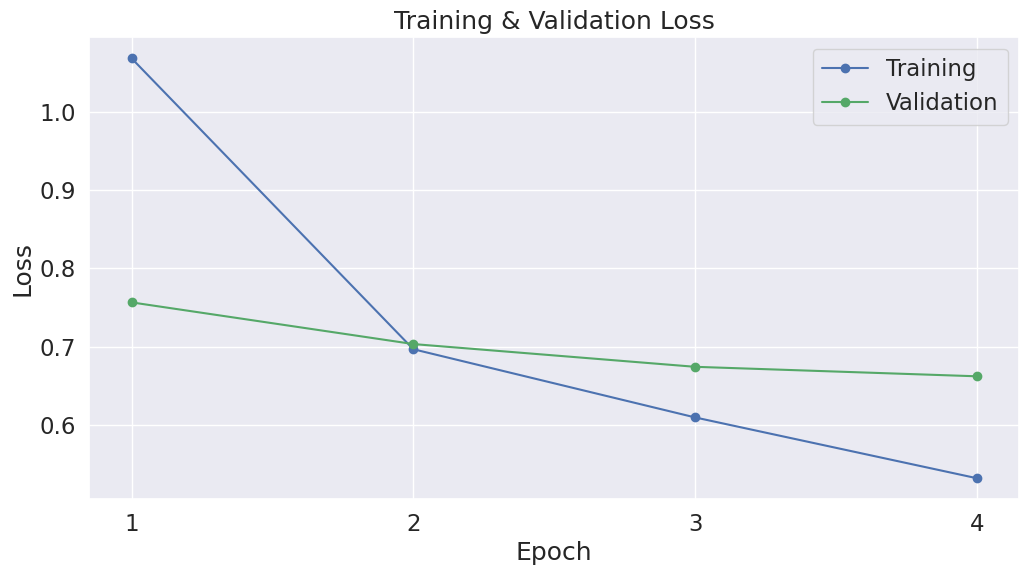

In [ ]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

In [ ]:
# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = '/content/drive/MyDrive/healthdataset/medquad_model'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))

Saving model to /content/drive/MyDrive/healthdataset/medquad_model


('/content/drive/MyDrive/healthdataset/medquad_model/tokenizer_config.json',
 '/content/drive/MyDrive/healthdataset/medquad_model/special_tokens_map.json',
 '/content/drive/MyDrive/healthdataset/medquad_model/vocab.json',
 '/content/drive/MyDrive/healthdataset/medquad_model/merges.txt',
 '/content/drive/MyDrive/healthdataset/medquad_model/added_tokens.json')

## Model save and evaluate


In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 38.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 22.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 67.8 MB/s eta 0:00:00


In [ ]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel

tokenizer = GPT2Tokenizer.from_pretrained('/content/drive/MyDrive/healthdataset/medquad_model')
model = GPT2LMHeadModel.from_pretrained('/content/drive/MyDrive/healthdataset/medquad_model')


In [ ]:
model.eval()
result=[]

# Prepare the input text
input_text = "shortness of breath is related to asthma"

# Encode the input text using the tokenizer
input_ids = tokenizer.encode(input_text, return_tensors='pt')
input_ids

# Generate the output sequence
output = model.generate(input_ids,
                                    do_sample=True,   
                                    top_k=50, 
                                    max_length = 100,
                                    top_p=0.95,
                                    temperature=1,                         
                                    num_return_sequences=3)
# Decode the output sequence
# output = model.generate(input_ids, max_length=1000, do_sample=True)
a = []
# for i, sample_output in enumerate(output):
#   a.append(sample_output)
#   print("{}: {}\n\n".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))
#   generated_text = tokenizer.decode(sample_output, skip_special_tokens=True)
#   # answer = generated_text.replace(sample_output, '').strip()
#   # result.append(answer)
for i, sample_output in enumerate(output):
  a.append(sample_output)
  generated_text = tokenizer.decode(sample_output, skip_special_tokens=True)
  answer = generated_text.replace(input_text, '').strip()
  result.append(answer)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [ ]:
result



['and allergy symptoms. This is true even if you have only a single asthma attack. When you have these symptoms and the symptoms are mild asthma attacks are less likely to occur. Although the condition is different than asthma in many cases the allergic reactions to the disease are the same. This is called allergic asthma.',
 'inhalation. When your airways are not functioning properly you can inhale too much air. Your nose is the only symptom. Your throat is the only symptom. You could have a bacterial or viral infection. A lung infection can be a skin problem or a allergy. Certain medicines can cause lung infections while other conditions can be life-threatening. The cause of asthma is not known. There is no specific medicine to treat asthma. The medicines have all been tried',
 'asthma which causes wheezing or a whistling sound when you breathe. People who have asthma are about two times more likely than nonspics to have asthma.2 However people who have asthma who do not have asthma 

In [ ]:
import numpy as np
import torch

In [ ]:

perplexity=[]
# by using the previous
for x in a:
  input_ids = x
  # print(sample_output)

  # Calculate the perplexity of the generated text
  loss = model(input_ids, labels=input_ids).loss
  perplex = torch.exp(loss)
  perplexity.append(perplex.item())
best_sentence_index = perplexity.index(min(perplexity))
print(result[best_sentence_index])

inhalation. When your airways are not functioning properly you can inhale too much air. Your nose is the only symptom. Your throat is the only symptom. You could have a bacterial or viral infection. A lung infection can be a skin problem or a allergy. Certain medicines can cause lung infections while other conditions can be life-threatening. The cause of asthma is not known. There is no specific medicine to treat asthma. The medicines have all been tried


In [ ]:
perplexity

[1.6586989644461323e+20, 6.521430015563965, 6.826442241668701]

In [ ]:
# givining the values to the perplexity metrix
query = input_text
generated_sentences = result
# Calculate perplexity scores for each generated sentence
perplexities = []
for sentence in generated_sentences:
    input_ids = tokenizer.encode(query + " " + sentence, return_tensors="pt")
    with torch.no_grad():
        logits = model(input_ids)[0]
    perplexity = np.exp(torch.mean(torch.nn.functional.cross_entropy(
        logits.view(-1, logits.size(-1)), input_ids.view(-1)
    ), dim=0))
    perplexities.append(perplexity.item())

# Select the sentence with the lowest perplexity
best_sentence_index = perplexities.index(min(perplexities))
best_sentence = generated_sentences[best_sentence_index]
print("------->>>>best sentences value",best_sentence)

print("Query:", query)
print("Generated sentences:")
for sentence, perplexity in zip(generated_sentences, perplexities):
    print("-" * 50)
    print("Sentence:", sentence)
    print("Perplexity:", perplexity)
print("Best sentence:", best_sentence)


---------->> index of perplexity 0
------->>>>best sentences value . It is more common in people who do not have asthma. If you have asthma you are at greater risk for lung diseases like bronchitis inflammation of the bronchi and asthma. In addition you may be at greater risk for more serious lung diseases like pneumonia asthma or lung cancer.
Query: shortness of breath is related to asthma
Generated sentences:
--------------------------------------------------
Sentence: . It is more common in people who do not have asthma. If you have asthma you are at greater risk for lung diseases like bronchitis inflammation of the bronchi and asthma. In addition you may be at greater risk for more serious lung diseases like pneumonia asthma or lung cancer.
Perplexity: 31846.9296875
--------------------------------------------------
Sentence: . Asthma is a breathing disorder that causes problems with how the airways work. Most people have asthma. Symptoms may vary in severity. They include wheezing

In [ ]:
perplexities

[54972.11328125, 123904.1484375, 74472.9453125]